In [16]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,AveragePooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, Callback, ReduceLROnPlateau 
from IPython.display import clear_output

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [18]:
model = Sequential()
input_shape = (512, 512, 4)

model.add(Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu'))
model.add(Flatten())
model.add(Dense(128, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model.add(Dropout(0.50))

model.add(Dense(1))

model.compile(
    loss = tf.keras.losses.MeanSquaredError(),    
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), 
             tf.keras.metrics.BinaryAccuracy(name="accuracy")],
    optimizer = tf.keras.optimizers.Adam(1e-4))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      1184      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16777344  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [19]:
class PlotLearning(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.metrics = {}
        self.metrics["loss"]=[]
        self.metrics["val_loss"]=[]
        self.metrics["accuracy"]=[]
        self.metrics["val_accuracy"]=[]
        self.metrics["lr"]=[]
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
        
        metrics = [x for x in logs if x in self.metrics and "val" not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                    self.metrics[metric], 
                    label=metric)
            if metric != "lr" and logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()
            if metric == "lr":
                axs[i].set_ylim(bottom=0, top=0.0015)
            else:
                axs[i].set_ylim(bottom=0, top=1)

        plt.tight_layout()
        plt.show()

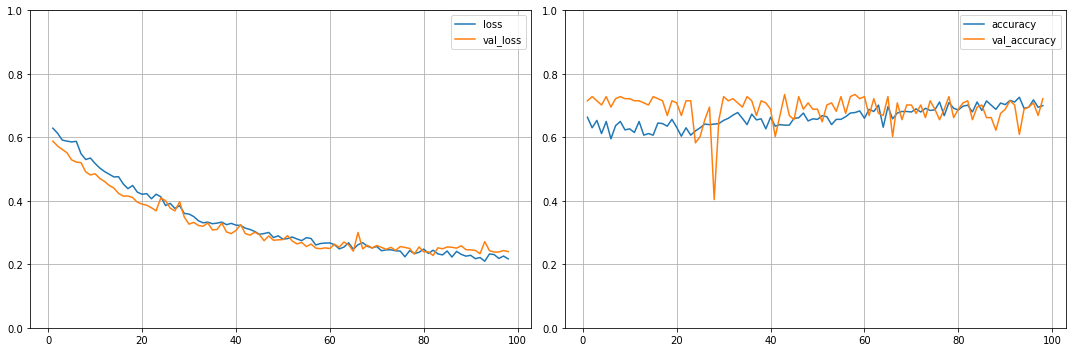

In [47]:
earstop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 16)
history = model.fit(
    X_train,
    y_train,
    epochs = 1000,
    batch_size=32,
    validation_data = (X_test,y_test),
    shuffle=True,
    verbose = 1,
    callbacks = [PlotLearning(), earstop]
)

In [48]:
print(f"Epochs: {len(history.history['accuracy'])}")
print(f"Accuracy: {history.history['accuracy'][-1]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Loss: {history.history['loss'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")
pred=model.predict(test_images)

Epochs: 98
Accuracy: 0.6998341679573059
Validation Accuracy: 0.7218543291091919
Loss: 0.21713881194591522
Validation Loss: 0.23999549448490143


In [23]:
inputs = keras.Input(shape=(512,512, 4), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)
 
x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])
 
x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])
 
x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_3_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_4_output = layers.add([x, block_3_output])
 
x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_4_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_5_output = layers.add([x, block_4_output])
 
x = layers.Conv2D(64, 3, activation="relu")(block_5_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(9)(x)
 
model = keras.Model(inputs, outputs, name="resnet")
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 510, 510, 32) 1184        img[0][0]                        
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 508, 508, 64) 18496       conv2d_14[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 169, 169, 64) 0           conv2d_15[0][0]                  
_____________________________________________________________________________________________

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ["acc"])
earstop=EarlyStopping(monitor='val_acc',min_delta=0,patience=10,verbose=1,
                    mode='auto')
history = model.fit(X_train, y_train, batch_size=64, epochs=200, 
                    validation_data=(X_test, y_test),callbacks=[PlotLearning(), earstop])

In [ ]:
print(f"Epochs: {len(history.history['accuracy'])}")
print(f"Accuracy: {history.history['accuracy'][-1]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Loss: {history.history['loss'][-1]}")
print(f"Validation Loss: {history.history['val_loss'][-1]}")
res_pred=model_resnet.predict(test_images)